0To train the model, the project utilizes a UTKFace dataset containing labeled facial images. The labels of each face image is embedded in the file name,
formated like [age]_[gender]_[race]_[date&time].jpg

[age] is an integer from 0 to 116, indicating the age

[gender] is either 0 (male) or 1 (female)

[race] is an integer from 0 to 4, denoting White=0, Black=1, Asian=2, Indian=3, and Others=4 (like Hispanic, Latino, Middle Eastern).

[date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace


In [1]:
import os
import re
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

import tensorflow.keras.applications
from PIL import Image
import cv2
import pickle
import tensorflow as tf
from keras.losses import huber_loss
from pydeck.bindings import layer
from scipy.special.cython_special import eval_sh_legendre
from tensorflow.compiler.tf2xla.python.xla import while_loop
from tensorflow.keras import Model, layers, regularizers
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber
from tensorflow.python.keras.callbacks import ModelCheckpoint

2025-07-14 16:00:17.951308: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Handle File names to extact age gender race

In [2]:
# add file folder path dir and using regular expression to
# parse the filenames

dataset_path = '../data/utkface_dataset'
pattern = r"(\d+)_(\d)_(\d)_(\d+).jpg"

image_size = (300, 300)
batch_size = 32

def parse_label(filename):
    match = re.match(pattern, filename)
    if match:
        age = int(match.group(1))
        gender = int(match.group(2))
        race = int(match.group(3))
        return age, gender, race
    else:
        raise IOError(f'{filename} Invalid filename')


Raw dataset preparation

In [1]:
def plot_distribution(files):
    ages = [parse_label(os.path.basename(f))[0] for f in files]
    genders = [parse_label(os.path.basename(f))[1] for f in files]
    races = [parse_label(os.path.basename(f))[2] for f in files]

    plt.figure(figsize=(8, 5))
    plt.hist(ages, bins=24, color='yellow', edgecolor='black')
    plt.title('Age Distribution in UTKFace Dataset')
    plt.xlabel('Age')
    plt.ylabel('Frenquency')
    plt.show()

    plt.figure(figsize=(8, 5))
    gender_count = Counter(genders)
    plt.bar(gender_count.keys(), gender_count.values(), color=['yellow', 'pink'])
    plt.xticks([0,1], ['Male', 'Female'])
    plt.title('Gender Distribution in UTKFace Dataset')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.show()

    plt.figure(figsize=(8, 5))
    race_counts = Counter(races)
    # White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
    plt.bar(race_counts.keys(), race_counts.values(), color=['gray','black', 'yellow', 'brown', 'red'])
    plt.xticks([0,1,2,3,4],['White-0', 'Black-1', 'Asian-2', 'Indian-3', 'Others-4'])
    plt.title('Race Distribution in UTKFace Dataset')
    plt.xlabel('Race')
    plt.ylabel('Count')
    plt.show()

all_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.jpg')]

plot_distribution(all_files)




NameError: name 'os' is not defined

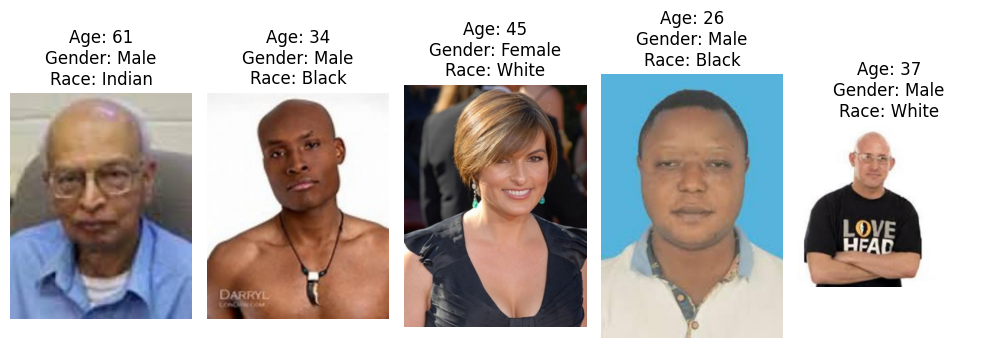

In [8]:
# Convert gender and race to string labels
def convert_labels(age, gender, race):
    gender_label = "Male" if gender == 0 else "Female"
    race_dict = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Others"}
    race_label = race_dict.get(race, "Unknown")
    return age, gender_label, race_label

random_files = random.sample(all_files, 5)

plt.figure(figsize=(10, 8))

for i, file_name in enumerate(random_files):
    img_path = file_name
    img = Image.open(img_path)

    base_name = os.path.basename(file_name)
    age, gender, race = parse_label(base_name)
    age, gender_label, race_label = convert_labels(age, gender, race)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Age: {age}\nGender: {gender_label}\nRace: {race_label}")

plt.tight_layout()
plt.show()

In [9]:
def load_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = preprocess_input(image)

    age, gender, race = label
    return image, (age, gender, race)


def create_dataset(image_files):
    labels = [parse_label(os.path.basename(file)) for file in image_files]
    ages = tf.constant([label[0] for label in labels], dtype=tf.int32)
    genders = tf.constant([label[1] for label in labels], dtype=tf.int32)
    races = tf.constant([label[2] for label in labels], dtype=tf.int32)

    dataset = tf.data.Dataset.from_tensor_slices((image_files, (ages, genders, races)))
    dataset = dataset.map(lambda x, y: (load_image(x, y)), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [10]:
# Get all image files
total_files = len(all_files)

# Shuffle files with a consistent seed
seed = 42
random.seed(seed)
random.shuffle(all_files)

# Split the data into train, validation, and test
train_split = 0.5
val_split = 0.25
test_split = 0.25

train_count = int(total_files * train_split)
val_count = int(total_files * val_split)

train_files = all_files[:train_count]
val_files = all_files[train_count:train_count + val_count]
test_files = all_files[train_count + val_count:]

# Create dataset for each subset
train_ds = create_dataset(train_files)
val_ds = create_dataset(val_files)
test_ds = create_dataset(test_files)

2025-07-14 16:06:05.302016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


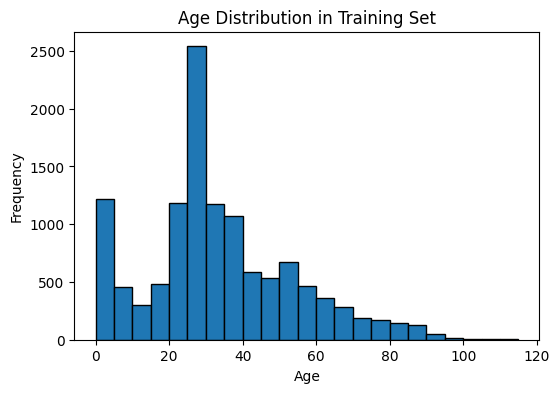

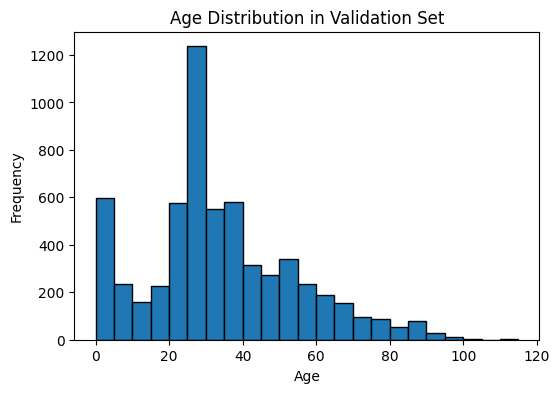

2025-07-14 16:07:14.543051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


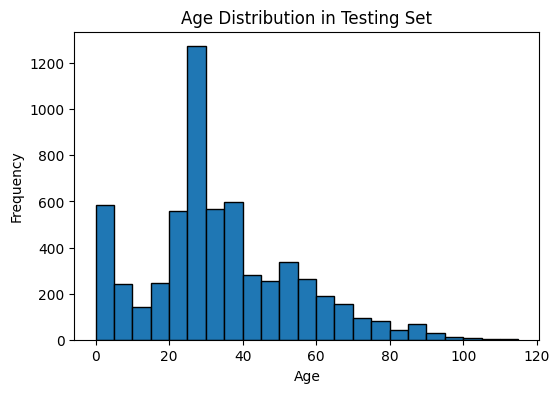

In [11]:
def plot_age_distribution(dataset, subset_name):
    ages = []
    for _, (age_labels, _, _) in dataset:
        ages.extend(age_labels.numpy())

    plt.figure(figsize=(6, 4))
    plt.hist(ages, bins=range(0, 120, 5), edgecolor='black')
    plt.title(f"Age Distribution in {subset_name} Set")
    plt.xlabel("Age")
    plt.ylabel("Frequency")
    plt.show()

# Plot age distributions for training, validation, and test sets
plot_age_distribution(train_ds, "Training")
plot_age_distribution(val_ds, "Validation")
plot_age_distribution(test_ds, "Testing")

2025-07-13 21:22:30.771361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: premature end of data segment


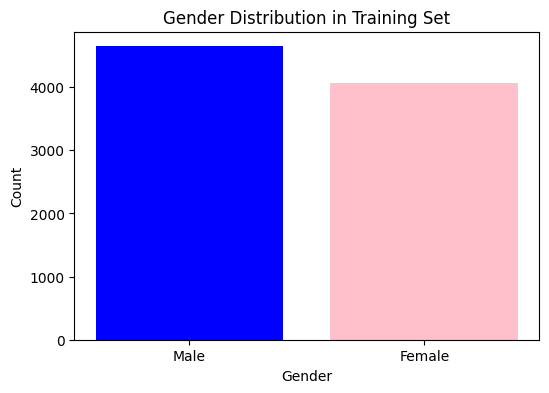

Corrupt JPEG data: premature end of data segment


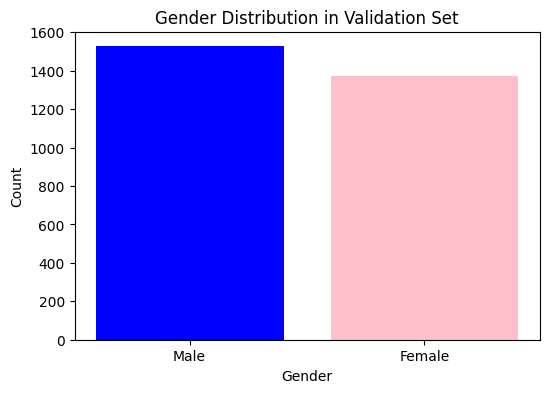

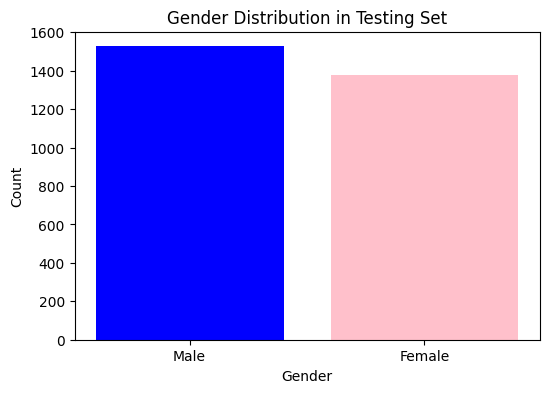

In [10]:
def plot_gender_distribution(dataset, subset_name):
    gender_count = {0: 0, 1: 0}
    for _, (_, gender_labels, _) in dataset:
        unique, counts = np.unique(gender_labels.numpy(), return_counts=True)
        for u, c in zip(unique, counts):
            gender_count[u] += c

    plt.figure(figsize=(6, 4))
    plt.bar(['Male', 'Female'], [gender_count[0], gender_count[1]], color=['blue', 'pink'])
    plt.title(f"Gender Distribution in {subset_name} Set")
    plt.xlabel("Gender")
    plt.ylabel("Count")
    plt.show()

# Plot gender distributions for training, validation, and test sets
plot_gender_distribution(train_ds, "Training")
plot_gender_distribution(val_ds, "Validation")
plot_gender_distribution(test_ds, "Testing")

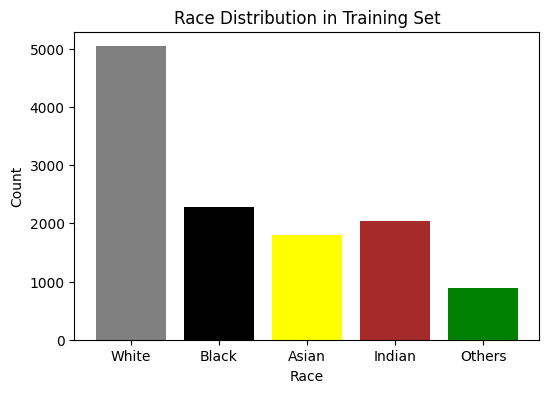

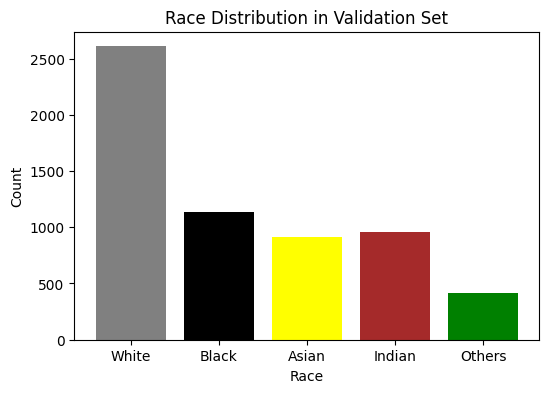

2025-07-14 16:09:06.742551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


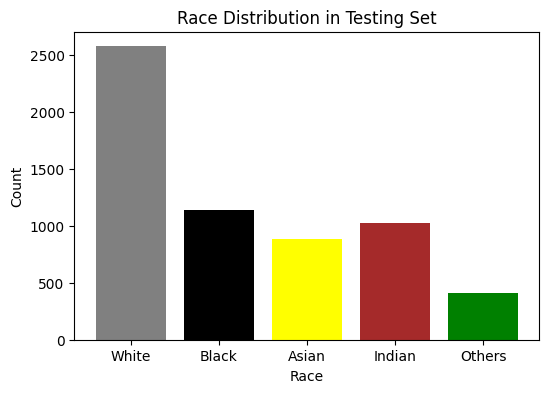

In [12]:
def plot_race_distribution(dataset, subset_name):
    race_count = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
    for _, (_, _, race_labels) in dataset:
        unique, counts = np.unique(race_labels.numpy(), return_counts=True)
        for u, c in zip(unique, counts):
            race_count[u] += c

    plt.figure(figsize=(6, 4))
    plt.bar(['White', 'Black', 'Asian', 'Indian', 'Others'],
            [race_count[i] for i in range(5)], color=['gray', 'black', 'yellow', 'brown', 'green'])
    plt.title(f"Race Distribution in {subset_name} Set")
    plt.xlabel("Race")
    plt.ylabel("Count")
    plt.show()

# Plot race distributions for training, validation, and test sets
plot_race_distribution(train_ds, "Training")
plot_race_distribution(val_ds, "Validation")
plot_race_distribution(test_ds, "Testing")

In [48]:
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights=None,
    input_shape=input_shape,
    pooling='avg'
)

weights_path = os.path.join('../models', 'efficientnetv2-s_notop.h5')

base_model.load_weights(weights_path)

base_model.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_11 (Rescaling)       (None, 224, 224, 3)  0           ['input_21[0][0]']               
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling_11[0][0]']           
                                )                                                                 
                                                                                   

In [54]:
#freeze all layers and adding age, gender, race output
inputs = tf.keras.layers.Input(shape=input_shape)

base_model.trainable = False

x = base_model(inputs, training=False)
# x = layers.GlobalAveragePooling2D()(x)

age_branch = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
age_branch = layers.BatchNormalization()(age_branch)
age_branch = layers.Dropout(0.5)(age_branch)
age_output = layers.Dense(1, activation='relu', name='age')(age_branch)

gender_branch = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
gender_branch = layers.BatchNormalization()(gender_branch)
gender_branch = layers.Dropout(0.5)(gender_branch)
gender_output = layers.Dense(1, activation='softmax', name='gender')(gender_branch)

race_branch = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
race_branch = layers.BatchNormalization()(race_branch)
race_branch = layers.Dropout(0.5)(race_branch)
race_output = layers.Dense(5, activation='softmax', name='race')(race_branch)

model = Model(inputs=inputs, outputs=[age_output, gender_output, race_output])

In [55]:
huber_loss = Huber()
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss={
        'age': huber_loss,
        'gender': 'binary_crossentropy',
        'race': 'sparse_categorical_crossentropy',
    },
    metrics={
        'age': 'mae',
        'gender': 'accuracy',
        'race': 'accuracy',
    }
)

In [56]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetv2-s (Functional)  (None, 1280)         20331360    ['input_23[0][0]']               
                                                                                                  
 dense_13 (Dense)               (None, 128)          163968      ['efficientnetv2-s[1][0]']       
                                                                                                  
 dense_14 (Dense)               (None, 128)          163968      ['efficientnetv2-s[1][0]'] 

In [57]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_efficientnetv2s.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [58]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)

Epoch 1/50
157/273 [================>.............] - ETA: 5:08 - loss: 32.6255 - age_loss: 25.5811 - gender_loss: 0.3727 - race_loss: 1.4433 - age_mae: 26.0795 - gender_accuracy: 0.4691 - race_accuracy: 0.5480

2025-07-13 22:43:38.698524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:42 - loss: 29.2034 - age_loss: 22.8478 - gender_loss: 0.3624 - race_loss: 1.3375 - age_mae: 23.3453 - gender_accuracy: 0.4673 - race_accuracy: 0.5711

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 28.0437 - age_loss: 21.9347 - gender_loss: 0.3570 - race_loss: 1.3141 - age_mae: 22.4318 - gender_accuracy: 0.4666 - race_accuracy: 0.5749

Corrupt JPEG data: premature end of data segment



Epoch 00001: val_loss improved from inf to 17.81532, saving model to best_efficientnetv2s.h5
273/273 [==============================] - 1061s 4s/step - loss: 28.0437 - age_loss: 21.9347 - gender_loss: 0.3570 - race_loss: 1.3141 - age_mae: 22.4318 - gender_accuracy: 0.4666 - race_accuracy: 0.5749 - val_loss: 17.8153 - val_age_loss: 13.7473 - val_gender_loss: 0.2650 - val_race_loss: 0.8736 - val_age_mae: 14.2398 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7081 - lr: 0.0010
Epoch 2/50
157/273 [================>.............] - ETA: 6:22 - loss: 17.4343 - age_loss: 13.5701 - gender_loss: 0.2948 - race_loss: 0.9711 - age_mae: 14.0641 - gender_accuracy: 0.4691 - race_accuracy: 0.6606

2025-07-13 23:02:49.123625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 2:23 - loss: 16.4289 - age_loss: 12.6845 - gender_loss: 0.3005 - race_loss: 0.9643 - age_mae: 13.1777 - gender_accuracy: 0.4673 - race_accuracy: 0.6600

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 16.1257 - age_loss: 12.4251 - gender_loss: 0.2999 - race_loss: 0.9713 - age_mae: 12.9183 - gender_accuracy: 0.4666 - race_accuracy: 0.6560

Corrupt JPEG data: premature end of data segment



Epoch 00002: val_loss improved from 17.81532 to 12.70955, saving model to best_efficientnetv2s.h5
273/273 [==============================] - 1308s 5s/step - loss: 16.1257 - age_loss: 12.4251 - gender_loss: 0.2999 - race_loss: 0.9713 - age_mae: 12.9183 - gender_accuracy: 0.4666 - race_accuracy: 0.6560 - val_loss: 12.7096 - val_age_loss: 9.5213 - val_gender_loss: 0.2608 - val_race_loss: 0.8571 - val_age_mae: 10.0108 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.6954 - lr: 0.0010
Epoch 3/50
157/273 [================>.............] - ETA: 5:43 - loss: 13.3788 - age_loss: 10.2333 - gender_loss: 0.2779 - race_loss: 0.8922 - age_mae: 10.7249 - gender_accuracy: 0.4691 - race_accuracy: 0.6815

2025-07-13 23:23:44.129137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:51 - loss: 13.1891 - age_loss: 10.0764 - gender_loss: 0.2863 - race_loss: 0.8937 - age_mae: 10.5677 - gender_accuracy: 0.4673 - race_accuracy: 0.6807

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 13.1865 - age_loss: 10.0818 - gender_loss: 0.2870 - race_loss: 0.9007 - age_mae: 10.5729 - gender_accuracy: 0.4666 - race_accuracy: 0.6793

Corrupt JPEG data: premature end of data segment



Epoch 00003: val_loss improved from 12.70955 to 12.23461, saving model to best_efficientnetv2s.h5
273/273 [==============================] - 1065s 4s/step - loss: 13.1865 - age_loss: 10.0818 - gender_loss: 0.2870 - race_loss: 0.9007 - age_mae: 10.5729 - gender_accuracy: 0.4666 - race_accuracy: 0.6793 - val_loss: 12.2346 - val_age_loss: 9.3202 - val_gender_loss: 0.2548 - val_race_loss: 0.8469 - val_age_mae: 9.8096 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7043 - lr: 0.0010
Epoch 4/50
157/273 [================>.............] - ETA: 5:42 - loss: 12.5340 - age_loss: 9.5944 - gender_loss: 0.2765 - race_loss: 0.8707 - age_mae: 10.0858 - gender_accuracy: 0.4691 - race_accuracy: 0.6869

2025-07-13 23:41:26.947057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:51 - loss: 12.4721 - age_loss: 9.5418 - gender_loss: 0.2825 - race_loss: 0.8683 - age_mae: 10.0331 - gender_accuracy: 0.4673 - race_accuracy: 0.6902

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 12.4790 - age_loss: 9.5486 - gender_loss: 0.2818 - race_loss: 0.8741 - age_mae: 10.0397 - gender_accuracy: 0.4666 - race_accuracy: 0.6890

Corrupt JPEG data: premature end of data segment



Epoch 00004: val_loss improved from 12.23461 to 11.83331, saving model to best_efficientnetv2s.h5
273/273 [==============================] - 1063s 4s/step - loss: 12.4790 - age_loss: 9.5486 - gender_loss: 0.2818 - race_loss: 0.8741 - age_mae: 10.0397 - gender_accuracy: 0.4666 - race_accuracy: 0.6890 - val_loss: 11.8333 - val_age_loss: 8.9856 - val_gender_loss: 0.2594 - val_race_loss: 0.8462 - val_age_mae: 9.4737 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7095 - lr: 0.0010
Epoch 5/50
157/273 [================>.............] - ETA: 5:42 - loss: 12.2489 - age_loss: 9.3687 - gender_loss: 0.2749 - race_loss: 0.8650 - age_mae: 9.8596 - gender_accuracy: 0.4691 - race_accuracy: 0.6939

2025-07-13 23:59:10.598854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:52 - loss: 12.2185 - age_loss: 9.3287 - gender_loss: 0.2836 - race_loss: 0.8678 - age_mae: 9.8190 - gender_accuracy: 0.4673 - race_accuracy: 0.6912

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 12.2467 - age_loss: 9.3502 - gender_loss: 0.2836 - race_loss: 0.8740 - age_mae: 9.8405 - gender_accuracy: 0.4666 - race_accuracy: 0.6889

Corrupt JPEG data: premature end of data segment



Epoch 00005: val_loss improved from 11.83331 to 11.59901, saving model to best_efficientnetv2s.h5
273/273 [==============================] - 1059s 4s/step - loss: 12.2467 - age_loss: 9.3502 - gender_loss: 0.2836 - race_loss: 0.8740 - age_mae: 9.8405 - gender_accuracy: 0.4666 - race_accuracy: 0.6889 - val_loss: 11.5990 - val_age_loss: 8.7561 - val_gender_loss: 0.2578 - val_race_loss: 0.8431 - val_age_mae: 9.2450 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7092 - lr: 0.0010
Epoch 6/50
157/273 [================>.............] - ETA: 5:30 - loss: 12.0173 - age_loss: 9.1220 - gender_loss: 0.2789 - race_loss: 0.8521 - age_mae: 9.6103 - gender_accuracy: 0.4691 - race_accuracy: 0.6990

2025-07-14 00:16:33.056498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:48 - loss: 12.0094 - age_loss: 9.1059 - gender_loss: 0.2847 - race_loss: 0.8511 - age_mae: 9.5948 - gender_accuracy: 0.4673 - race_accuracy: 0.6973

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 12.0404 - age_loss: 9.1298 - gender_loss: 0.2851 - race_loss: 0.8557 - age_mae: 9.6189 - gender_accuracy: 0.4666 - race_accuracy: 0.6943

Corrupt JPEG data: premature end of data segment



Epoch 00006: val_loss did not improve from 11.59901
273/273 [==============================] - 1023s 4s/step - loss: 12.0404 - age_loss: 9.1298 - gender_loss: 0.2851 - race_loss: 0.8557 - age_mae: 9.6189 - gender_accuracy: 0.4666 - race_accuracy: 0.6943 - val_loss: 11.6643 - val_age_loss: 8.7824 - val_gender_loss: 0.2631 - val_race_loss: 0.8329 - val_age_mae: 9.2702 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7099 - lr: 0.0010
Epoch 7/50
157/273 [================>.............] - ETA: 5:21 - loss: 11.9144 - age_loss: 8.9634 - gender_loss: 0.2762 - race_loss: 0.8618 - age_mae: 9.4524 - gender_accuracy: 0.4691 - race_accuracy: 0.6893

2025-07-14 00:33:23.989899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:44 - loss: 11.9072 - age_loss: 8.9546 - gender_loss: 0.2825 - race_loss: 0.8597 - age_mae: 9.4434 - gender_accuracy: 0.4673 - race_accuracy: 0.6898

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 11.9346 - age_loss: 8.9736 - gender_loss: 0.2829 - race_loss: 0.8687 - age_mae: 9.4625 - gender_accuracy: 0.4666 - race_accuracy: 0.6855

Corrupt JPEG data: premature end of data segment



Epoch 00007: val_loss did not improve from 11.59901
273/273 [==============================] - 995s 4s/step - loss: 11.9346 - age_loss: 8.9736 - gender_loss: 0.2829 - race_loss: 0.8687 - age_mae: 9.4625 - gender_accuracy: 0.4666 - race_accuracy: 0.6855 - val_loss: 11.6130 - val_age_loss: 8.7309 - val_gender_loss: 0.2544 - val_race_loss: 0.8248 - val_age_mae: 9.2195 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7136 - lr: 0.0010
Epoch 8/50
157/273 [================>.............] - ETA: 5:16 - loss: 11.7344 - age_loss: 8.7855 - gender_loss: 0.2775 - race_loss: 0.8550 - age_mae: 9.2747 - gender_accuracy: 0.4691 - race_accuracy: 0.6949

2025-07-14 00:49:52.811678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:43 - loss: 11.7907 - age_loss: 8.8331 - gender_loss: 0.2818 - race_loss: 0.8576 - age_mae: 9.3221 - gender_accuracy: 0.4673 - race_accuracy: 0.6940

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 11.8106 - age_loss: 8.8447 - gender_loss: 0.2836 - race_loss: 0.8624 - age_mae: 9.3340 - gender_accuracy: 0.4666 - race_accuracy: 0.6916

Corrupt JPEG data: premature end of data segment



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00008: val_loss did not improve from 11.59901
273/273 [==============================] - 987s 4s/step - loss: 11.8106 - age_loss: 8.8447 - gender_loss: 0.2836 - race_loss: 0.8624 - age_mae: 9.3340 - gender_accuracy: 0.4666 - race_accuracy: 0.6916 - val_loss: 11.6577 - val_age_loss: 8.7399 - val_gender_loss: 0.2591 - val_race_loss: 0.8286 - val_age_mae: 9.2282 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7064 - lr: 0.0010
Epoch 9/50
157/273 [================>.............] - ETA: 5:15 - loss: 11.5989 - age_loss: 8.7446 - gender_loss: 0.2640 - race_loss: 0.8149 - age_mae: 9.2337 - gender_accuracy: 0.4691 - race_accuracy: 0.7098

2025-07-14 01:06:17.635099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:43 - loss: 11.4092 - age_loss: 8.5883 - gender_loss: 0.2661 - race_loss: 0.8052 - age_mae: 9.0776 - gender_accuracy: 0.4673 - race_accuracy: 0.7153

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 11.3722 - age_loss: 8.5633 - gender_loss: 0.2656 - race_loss: 0.8047 - age_mae: 9.0524 - gender_accuracy: 0.4666 - race_accuracy: 0.7159

Corrupt JPEG data: premature end of data segment



Epoch 00009: val_loss improved from 11.59901 to 11.40007, saving model to best_efficientnetv2s.h5
273/273 [==============================] - 981s 4s/step - loss: 11.3722 - age_loss: 8.5633 - gender_loss: 0.2656 - race_loss: 0.8047 - age_mae: 9.0524 - gender_accuracy: 0.4666 - race_accuracy: 0.7159 - val_loss: 11.4001 - val_age_loss: 8.6801 - val_gender_loss: 0.2578 - val_race_loss: 0.8033 - val_age_mae: 9.1695 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7229 - lr: 5.0000e-04
Epoch 10/50
157/273 [================>.............] - ETA: 5:14 - loss: 11.1741 - age_loss: 8.4897 - gender_loss: 0.2584 - race_loss: 0.7890 - age_mae: 8.9774 - gender_accuracy: 0.4691 - race_accuracy: 0.7174

2025-07-14 01:22:37.982295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:43 - loss: 11.0406 - age_loss: 8.3634 - gender_loss: 0.2634 - race_loss: 0.7889 - age_mae: 8.8519 - gender_accuracy: 0.4673 - race_accuracy: 0.7215

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 11.0113 - age_loss: 8.3382 - gender_loss: 0.2633 - race_loss: 0.7901 - age_mae: 8.8264 - gender_accuracy: 0.4666 - race_accuracy: 0.7199

Corrupt JPEG data: premature end of data segment



Epoch 00010: val_loss improved from 11.40007 to 11.38145, saving model to best_efficientnetv2s.h5
273/273 [==============================] - 980s 4s/step - loss: 11.0113 - age_loss: 8.3382 - gender_loss: 0.2633 - race_loss: 0.7901 - age_mae: 8.8264 - gender_accuracy: 0.4666 - race_accuracy: 0.7199 - val_loss: 11.3815 - val_age_loss: 8.7276 - val_gender_loss: 0.2508 - val_race_loss: 0.8206 - val_age_mae: 9.2164 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7140 - lr: 5.0000e-04
Epoch 11/50
157/273 [================>.............] - ETA: 5:13 - loss: 10.9419 - age_loss: 8.3421 - gender_loss: 0.2612 - race_loss: 0.7665 - age_mae: 8.8299 - gender_accuracy: 0.4691 - race_accuracy: 0.7289

2025-07-14 01:38:55.800409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:42 - loss: 10.9142 - age_loss: 8.3158 - gender_loss: 0.2651 - race_loss: 0.7675 - age_mae: 8.8035 - gender_accuracy: 0.4673 - race_accuracy: 0.7283

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 10.9003 - age_loss: 8.2998 - gender_loss: 0.2664 - race_loss: 0.7710 - age_mae: 8.7876 - gender_accuracy: 0.4666 - race_accuracy: 0.7248

Corrupt JPEG data: premature end of data segment



Epoch 00011: val_loss improved from 11.38145 to 11.10269, saving model to best_efficientnetv2s.h5
273/273 [==============================] - 978s 4s/step - loss: 10.9003 - age_loss: 8.2998 - gender_loss: 0.2664 - race_loss: 0.7710 - age_mae: 8.7876 - gender_accuracy: 0.4666 - race_accuracy: 0.7248 - val_loss: 11.1027 - val_age_loss: 8.5054 - val_gender_loss: 0.2475 - val_race_loss: 0.8067 - val_age_mae: 8.9921 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7185 - lr: 5.0000e-04
Epoch 12/50
157/273 [================>.............] - ETA: 5:14 - loss: 10.6385 - age_loss: 8.0782 - gender_loss: 0.2538 - race_loss: 0.7709 - age_mae: 8.5643 - gender_accuracy: 0.4691 - race_accuracy: 0.7261

2025-07-14 01:55:15.160318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:42 - loss: 10.6248 - age_loss: 8.0714 - gender_loss: 0.2564 - race_loss: 0.7669 - age_mae: 8.5575 - gender_accuracy: 0.4673 - race_accuracy: 0.7295

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 10.6330 - age_loss: 8.0764 - gender_loss: 0.2574 - race_loss: 0.7716 - age_mae: 8.5628 - gender_accuracy: 0.4666 - race_accuracy: 0.7288

Corrupt JPEG data: premature end of data segment



Epoch 00012: val_loss did not improve from 11.10269
273/273 [==============================] - 977s 4s/step - loss: 10.6330 - age_loss: 8.0764 - gender_loss: 0.2574 - race_loss: 0.7716 - age_mae: 8.5628 - gender_accuracy: 0.4666 - race_accuracy: 0.7288 - val_loss: 11.1714 - val_age_loss: 8.6022 - val_gender_loss: 0.2504 - val_race_loss: 0.8103 - val_age_mae: 9.0891 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7136 - lr: 5.0000e-04
Epoch 13/50
157/273 [================>.............] - ETA: 5:13 - loss: 10.6267 - age_loss: 8.1055 - gender_loss: 0.2522 - race_loss: 0.7661 - age_mae: 8.5933 - gender_accuracy: 0.4691 - race_accuracy: 0.7251

2025-07-14 02:11:30.542134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:42 - loss: 10.5640 - age_loss: 8.0497 - gender_loss: 0.2568 - race_loss: 0.7587 - age_mae: 8.5376 - gender_accuracy: 0.4673 - race_accuracy: 0.7315

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 10.5511 - age_loss: 8.0319 - gender_loss: 0.2567 - race_loss: 0.7654 - age_mae: 8.5197 - gender_accuracy: 0.4666 - race_accuracy: 0.7272

Corrupt JPEG data: premature end of data segment



Epoch 00013: val_loss improved from 11.10269 to 11.05146, saving model to best_efficientnetv2s.h5
273/273 [==============================] - 974s 4s/step - loss: 10.5511 - age_loss: 8.0319 - gender_loss: 0.2567 - race_loss: 0.7654 - age_mae: 8.5197 - gender_accuracy: 0.4666 - race_accuracy: 0.7272 - val_loss: 11.0515 - val_age_loss: 8.5056 - val_gender_loss: 0.2440 - val_race_loss: 0.8164 - val_age_mae: 8.9942 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7185 - lr: 5.0000e-04
Epoch 14/50
157/273 [================>.............] - ETA: 5:11 - loss: 10.4999 - age_loss: 8.0174 - gender_loss: 0.2468 - race_loss: 0.7476 - age_mae: 8.5061 - gender_accuracy: 0.4691 - race_accuracy: 0.7357

2025-07-14 02:27:41.524140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:41 - loss: 10.4644 - age_loss: 7.9741 - gender_loss: 0.2545 - race_loss: 0.7497 - age_mae: 8.4630 - gender_accuracy: 0.4673 - race_accuracy: 0.7375

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 10.4836 - age_loss: 7.9873 - gender_loss: 0.2553 - race_loss: 0.7557 - age_mae: 8.4759 - gender_accuracy: 0.4666 - race_accuracy: 0.7330

Corrupt JPEG data: premature end of data segment



Epoch 00014: val_loss did not improve from 11.05146
273/273 [==============================] - 968s 4s/step - loss: 10.4836 - age_loss: 7.9873 - gender_loss: 0.2553 - race_loss: 0.7557 - age_mae: 8.4759 - gender_accuracy: 0.4666 - race_accuracy: 0.7330 - val_loss: 11.1069 - val_age_loss: 8.5667 - val_gender_loss: 0.2444 - val_race_loss: 0.8179 - val_age_mae: 9.0562 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7150 - lr: 5.0000e-04
Epoch 15/50
157/273 [================>.............] - ETA: 5:11 - loss: 10.4332 - age_loss: 7.9562 - gender_loss: 0.2505 - race_loss: 0.7454 - age_mae: 8.4445 - gender_accuracy: 0.4691 - race_accuracy: 0.7311

2025-07-14 02:43:49.897354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:41 - loss: 10.4462 - age_loss: 7.9625 - gender_loss: 0.2552 - race_loss: 0.7497 - age_mae: 8.4499 - gender_accuracy: 0.4673 - race_accuracy: 0.7316

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 10.4473 - age_loss: 7.9590 - gender_loss: 0.2556 - race_loss: 0.7550 - age_mae: 8.4464 - gender_accuracy: 0.4666 - race_accuracy: 0.7272

Corrupt JPEG data: premature end of data segment



Epoch 00015: val_loss did not improve from 11.05146
273/273 [==============================] - 968s 4s/step - loss: 10.4473 - age_loss: 7.9590 - gender_loss: 0.2556 - race_loss: 0.7550 - age_mae: 8.4464 - gender_accuracy: 0.4666 - race_accuracy: 0.7272 - val_loss: 11.1023 - val_age_loss: 8.5791 - val_gender_loss: 0.2495 - val_race_loss: 0.8030 - val_age_mae: 9.0671 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7164 - lr: 5.0000e-04
Epoch 16/50
157/273 [================>.............] - ETA: 5:10 - loss: 10.3289 - age_loss: 7.8793 - gender_loss: 0.2382 - race_loss: 0.7389 - age_mae: 8.3670 - gender_accuracy: 0.4691 - race_accuracy: 0.7317

2025-07-14 02:59:55.629758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:41 - loss: 10.3038 - age_loss: 7.8423 - gender_loss: 0.2462 - race_loss: 0.7452 - age_mae: 8.3295 - gender_accuracy: 0.4673 - race_accuracy: 0.7287

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 10.2946 - age_loss: 7.8292 - gender_loss: 0.2479 - race_loss: 0.7481 - age_mae: 8.3162 - gender_accuracy: 0.4666 - race_accuracy: 0.7275

Corrupt JPEG data: premature end of data segment



Epoch 00016: val_loss improved from 11.05146 to 11.00002, saving model to best_efficientnetv2s.h5
273/273 [==============================] - 963s 4s/step - loss: 10.2946 - age_loss: 7.8292 - gender_loss: 0.2479 - race_loss: 0.7481 - age_mae: 8.3162 - gender_accuracy: 0.4666 - race_accuracy: 0.7275 - val_loss: 11.0000 - val_age_loss: 8.4824 - val_gender_loss: 0.2459 - val_race_loss: 0.8084 - val_age_mae: 8.9685 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7161 - lr: 5.0000e-04
Epoch 17/50
157/273 [================>.............] - ETA: 5:08 - loss: 10.3274 - age_loss: 7.8826 - gender_loss: 0.2453 - race_loss: 0.7371 - age_mae: 8.3698 - gender_accuracy: 0.4691 - race_accuracy: 0.7335

2025-07-14 03:15:56.876015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:41 - loss: 10.3621 - age_loss: 7.9119 - gender_loss: 0.2496 - race_loss: 0.7383 - age_mae: 8.3995 - gender_accuracy: 0.4673 - race_accuracy: 0.7328

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 10.3824 - age_loss: 7.9290 - gender_loss: 0.2491 - race_loss: 0.7423 - age_mae: 8.4168 - gender_accuracy: 0.4666 - race_accuracy: 0.7322

Corrupt JPEG data: premature end of data segment



Epoch 00017: val_loss did not improve from 11.00002
273/273 [==============================] - 962s 4s/step - loss: 10.3824 - age_loss: 7.9290 - gender_loss: 0.2491 - race_loss: 0.7423 - age_mae: 8.4168 - gender_accuracy: 0.4666 - race_accuracy: 0.7322 - val_loss: 11.2008 - val_age_loss: 8.6904 - val_gender_loss: 0.2449 - val_race_loss: 0.8054 - val_age_mae: 9.1781 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7171 - lr: 5.0000e-04
Epoch 18/50
157/273 [================>.............] - ETA: 5:08 - loss: 10.2466 - age_loss: 7.8235 - gender_loss: 0.2393 - race_loss: 0.7210 - age_mae: 8.3105 - gender_accuracy: 0.4691 - race_accuracy: 0.7351

2025-07-14 03:31:58.510449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:40 - loss: 10.2173 - age_loss: 7.7800 - gender_loss: 0.2445 - race_loss: 0.7304 - age_mae: 8.2669 - gender_accuracy: 0.4673 - race_accuracy: 0.7330

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 10.2402 - age_loss: 7.7979 - gender_loss: 0.2459 - race_loss: 0.7343 - age_mae: 8.2851 - gender_accuracy: 0.4666 - race_accuracy: 0.7325

Corrupt JPEG data: premature end of data segment



Epoch 00018: val_loss did not improve from 11.00002
273/273 [==============================] - 960s 4s/step - loss: 10.2402 - age_loss: 7.7979 - gender_loss: 0.2459 - race_loss: 0.7343 - age_mae: 8.2851 - gender_accuracy: 0.4666 - race_accuracy: 0.7325 - val_loss: 11.0113 - val_age_loss: 8.4984 - val_gender_loss: 0.2425 - val_race_loss: 0.8092 - val_age_mae: 8.9865 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7157 - lr: 5.0000e-04
Epoch 19/50
157/273 [================>.............] - ETA: 5:07 - loss: 10.2283 - age_loss: 7.7919 - gender_loss: 0.2386 - race_loss: 0.7320 - age_mae: 8.2795 - gender_accuracy: 0.4691 - race_accuracy: 0.7389

2025-07-14 03:47:57.861458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:40 - loss: 10.2486 - age_loss: 7.8079 - gender_loss: 0.2453 - race_loss: 0.7303 - age_mae: 8.2959 - gender_accuracy: 0.4673 - race_accuracy: 0.7420

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 10.2304 - age_loss: 7.7845 - gender_loss: 0.2465 - race_loss: 0.7343 - age_mae: 8.2726 - gender_accuracy: 0.4666 - race_accuracy: 0.7392

Corrupt JPEG data: premature end of data segment



Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00019: val_loss did not improve from 11.00002
273/273 [==============================] - 959s 4s/step - loss: 10.2304 - age_loss: 7.7845 - gender_loss: 0.2465 - race_loss: 0.7343 - age_mae: 8.2726 - gender_accuracy: 0.4666 - race_accuracy: 0.7392 - val_loss: 11.0257 - val_age_loss: 8.4915 - val_gender_loss: 0.2513 - val_race_loss: 0.8178 - val_age_mae: 8.9797 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7123 - lr: 5.0000e-04
Epoch 20/50
157/273 [================>.............] - ETA: 5:06 - loss: 9.9258 - age_loss: 7.5611 - gender_loss: 0.2286 - race_loss: 0.6876 - age_mae: 8.0470 - gender_accuracy: 0.4691 - race_accuracy: 0.7538

2025-07-14 04:03:55.423024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:40 - loss: 9.8814 - age_loss: 7.5465 - gender_loss: 0.2244 - race_loss: 0.6713 - age_mae: 8.0331 - gender_accuracy: 0.4673 - race_accuracy: 0.7621

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 9.8524 - age_loss: 7.5246 - gender_loss: 0.2239 - race_loss: 0.6689 - age_mae: 8.0110 - gender_accuracy: 0.4666 - race_accuracy: 0.7617

Corrupt JPEG data: premature end of data segment



Epoch 00020: val_loss improved from 11.00002 to 10.89190, saving model to best_efficientnetv2s.h5
273/273 [==============================] - 956s 4s/step - loss: 9.8524 - age_loss: 7.5246 - gender_loss: 0.2239 - race_loss: 0.6689 - age_mae: 8.0110 - gender_accuracy: 0.4666 - race_accuracy: 0.7617 - val_loss: 10.8919 - val_age_loss: 8.4580 - val_gender_loss: 0.2394 - val_race_loss: 0.7902 - val_age_mae: 8.9432 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7278 - lr: 2.5000e-04
Epoch 21/50
157/273 [================>.............] - ETA: 5:07 - loss: 9.5730 - age_loss: 7.3400 - gender_loss: 0.2081 - race_loss: 0.6330 - age_mae: 7.8267 - gender_accuracy: 0.4691 - race_accuracy: 0.7755

2025-07-14 04:19:51.060044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:40 - loss: 9.4901 - age_loss: 7.2739 - gender_loss: 0.2093 - race_loss: 0.6212 - age_mae: 7.7598 - gender_accuracy: 0.4673 - race_accuracy: 0.7798

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 9.4872 - age_loss: 7.2746 - gender_loss: 0.2091 - race_loss: 0.6206 - age_mae: 7.7606 - gender_accuracy: 0.4666 - race_accuracy: 0.7801

Corrupt JPEG data: premature end of data segment



Epoch 00021: val_loss improved from 10.89190 to 10.82365, saving model to best_efficientnetv2s.h5
273/273 [==============================] - 957s 4s/step - loss: 9.4872 - age_loss: 7.2746 - gender_loss: 0.2091 - race_loss: 0.6206 - age_mae: 7.7606 - gender_accuracy: 0.4666 - race_accuracy: 0.7801 - val_loss: 10.8237 - val_age_loss: 8.4272 - val_gender_loss: 0.2412 - val_race_loss: 0.7929 - val_age_mae: 8.9147 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7285 - lr: 2.5000e-04
Epoch 22/50
157/273 [================>.............] - ETA: 5:07 - loss: 9.4856 - age_loss: 7.3069 - gender_loss: 0.2020 - race_loss: 0.6225 - age_mae: 7.7922 - gender_accuracy: 0.4691 - race_accuracy: 0.7793

2025-07-14 04:35:48.186965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:40 - loss: 9.4299 - age_loss: 7.2619 - gender_loss: 0.2059 - race_loss: 0.6124 - age_mae: 7.7473 - gender_accuracy: 0.4673 - race_accuracy: 0.7831

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 9.4112 - age_loss: 7.2458 - gender_loss: 0.2058 - race_loss: 0.6121 - age_mae: 7.7313 - gender_accuracy: 0.4666 - race_accuracy: 0.7810

Corrupt JPEG data: premature end of data segment



Epoch 00022: val_loss improved from 10.82365 to 10.81171, saving model to best_efficientnetv2s.h5
273/273 [==============================] - 957s 4s/step - loss: 9.4112 - age_loss: 7.2458 - gender_loss: 0.2058 - race_loss: 0.6121 - age_mae: 7.7313 - gender_accuracy: 0.4666 - race_accuracy: 0.7810 - val_loss: 10.8117 - val_age_loss: 8.4448 - val_gender_loss: 0.2392 - val_race_loss: 0.7954 - val_age_mae: 8.9321 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7323 - lr: 2.5000e-04
Epoch 23/50
157/273 [================>.............] - ETA: 5:06 - loss: 9.3320 - age_loss: 7.2043 - gender_loss: 0.2040 - race_loss: 0.5980 - age_mae: 7.6897 - gender_accuracy: 0.4691 - race_accuracy: 0.7894

2025-07-14 04:51:43.843479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:40 - loss: 9.2961 - age_loss: 7.1808 - gender_loss: 0.2043 - race_loss: 0.5887 - age_mae: 7.6660 - gender_accuracy: 0.4673 - race_accuracy: 0.7935

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 9.2739 - age_loss: 7.1584 - gender_loss: 0.2050 - race_loss: 0.5898 - age_mae: 7.6436 - gender_accuracy: 0.4666 - race_accuracy: 0.7913

Corrupt JPEG data: premature end of data segment



Epoch 00023: val_loss improved from 10.81171 to 10.77026, saving model to best_efficientnetv2s.h5
273/273 [==============================] - 958s 4s/step - loss: 9.2739 - age_loss: 7.1584 - gender_loss: 0.2050 - race_loss: 0.5898 - age_mae: 7.6436 - gender_accuracy: 0.4666 - race_accuracy: 0.7913 - val_loss: 10.7703 - val_age_loss: 8.4216 - val_gender_loss: 0.2374 - val_race_loss: 0.8018 - val_age_mae: 8.9088 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7257 - lr: 2.5000e-04
Epoch 24/50
157/273 [================>.............] - ETA: 5:05 - loss: 9.2354 - age_loss: 7.1594 - gender_loss: 0.1906 - race_loss: 0.5801 - age_mae: 7.6455 - gender_accuracy: 0.4691 - race_accuracy: 0.7856

2025-07-14 05:07:40.879361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:40 - loss: 9.1887 - age_loss: 7.1151 - gender_loss: 0.1919 - race_loss: 0.5793 - age_mae: 7.6015 - gender_accuracy: 0.4673 - race_accuracy: 0.7884

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 9.1639 - age_loss: 7.0871 - gender_loss: 0.1927 - race_loss: 0.5830 - age_mae: 7.5737 - gender_accuracy: 0.4666 - race_accuracy: 0.7857

Corrupt JPEG data: premature end of data segment



Epoch 00024: val_loss did not improve from 10.77026
273/273 [==============================] - 954s 3s/step - loss: 9.1639 - age_loss: 7.0871 - gender_loss: 0.1927 - race_loss: 0.5830 - age_mae: 7.5737 - gender_accuracy: 0.4666 - race_accuracy: 0.7857 - val_loss: 10.7947 - val_age_loss: 8.4576 - val_gender_loss: 0.2419 - val_race_loss: 0.8041 - val_age_mae: 8.9457 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7209 - lr: 2.5000e-04
Epoch 25/50
157/273 [================>.............] - ETA: 5:06 - loss: 9.1312 - age_loss: 7.1044 - gender_loss: 0.1864 - race_loss: 0.5540 - age_mae: 7.5916 - gender_accuracy: 0.4691 - race_accuracy: 0.8057

2025-07-14 05:23:35.020551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:40 - loss: 9.1320 - age_loss: 7.1042 - gender_loss: 0.1931 - race_loss: 0.5510 - age_mae: 7.5907 - gender_accuracy: 0.4673 - race_accuracy: 0.8064

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 9.1097 - age_loss: 7.0792 - gender_loss: 0.1921 - race_loss: 0.5557 - age_mae: 7.5656 - gender_accuracy: 0.4666 - race_accuracy: 0.8033

Corrupt JPEG data: premature end of data segment



Epoch 00025: val_loss improved from 10.77026 to 10.68251, saving model to best_efficientnetv2s.h5
273/273 [==============================] - 954s 3s/step - loss: 9.1097 - age_loss: 7.0792 - gender_loss: 0.1921 - race_loss: 0.5557 - age_mae: 7.5656 - gender_accuracy: 0.4666 - race_accuracy: 0.8033 - val_loss: 10.6825 - val_age_loss: 8.3539 - val_gender_loss: 0.2421 - val_race_loss: 0.8122 - val_age_mae: 8.8426 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7243 - lr: 2.5000e-04
Epoch 26/50
157/273 [================>.............] - ETA: 5:04 - loss: 8.9020 - age_loss: 6.8935 - gender_loss: 0.1809 - race_loss: 0.5564 - age_mae: 7.3783 - gender_accuracy: 0.4691 - race_accuracy: 0.7970

2025-07-14 05:39:26.329550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:39 - loss: 8.9264 - age_loss: 6.9190 - gender_loss: 0.1809 - race_loss: 0.5572 - age_mae: 7.4035 - gender_accuracy: 0.4673 - race_accuracy: 0.8013

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 8.9311 - age_loss: 6.9221 - gender_loss: 0.1824 - race_loss: 0.5582 - age_mae: 7.4070 - gender_accuracy: 0.4666 - race_accuracy: 0.8008

Corrupt JPEG data: premature end of data segment



Epoch 00026: val_loss improved from 10.68251 to 10.66954, saving model to best_efficientnetv2s.h5
273/273 [==============================] - 949s 3s/step - loss: 8.9311 - age_loss: 6.9221 - gender_loss: 0.1824 - race_loss: 0.5582 - age_mae: 7.4070 - gender_accuracy: 0.4666 - race_accuracy: 0.8008 - val_loss: 10.6695 - val_age_loss: 8.3553 - val_gender_loss: 0.2429 - val_race_loss: 0.8096 - val_age_mae: 8.8421 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7278 - lr: 2.5000e-04
Epoch 27/50
157/273 [================>.............] - ETA: 5:06 - loss: 8.9440 - age_loss: 6.9531 - gender_loss: 0.1870 - race_loss: 0.5444 - age_mae: 7.4378 - gender_accuracy: 0.4691 - race_accuracy: 0.8063

2025-07-14 05:55:17.618602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:40 - loss: 8.9460 - age_loss: 6.9601 - gender_loss: 0.1890 - race_loss: 0.5389 - age_mae: 7.4441 - gender_accuracy: 0.4673 - race_accuracy: 0.8066

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 8.9278 - age_loss: 6.9395 - gender_loss: 0.1910 - race_loss: 0.5400 - age_mae: 7.4236 - gender_accuracy: 0.4666 - race_accuracy: 0.8059

Corrupt JPEG data: premature end of data segment



Epoch 00027: val_loss did not improve from 10.66954
273/273 [==============================] - 952s 3s/step - loss: 8.9278 - age_loss: 6.9395 - gender_loss: 0.1910 - race_loss: 0.5400 - age_mae: 7.4236 - gender_accuracy: 0.4666 - race_accuracy: 0.8059 - val_loss: 10.6845 - val_age_loss: 8.3693 - val_gender_loss: 0.2476 - val_race_loss: 0.8159 - val_age_mae: 8.8573 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7209 - lr: 2.5000e-04
Epoch 28/50
157/273 [================>.............] - ETA: 5:05 - loss: 8.9698 - age_loss: 6.9960 - gender_loss: 0.1787 - race_loss: 0.5451 - age_mae: 7.4823 - gender_accuracy: 0.4691 - race_accuracy: 0.7970

2025-07-14 06:11:09.089168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:39 - loss: 8.9037 - age_loss: 6.9305 - gender_loss: 0.1811 - race_loss: 0.5437 - age_mae: 7.4165 - gender_accuracy: 0.4673 - race_accuracy: 0.8003

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 8.8733 - age_loss: 6.9000 - gender_loss: 0.1822 - race_loss: 0.5433 - age_mae: 7.3862 - gender_accuracy: 0.4666 - race_accuracy: 0.8013

Corrupt JPEG data: premature end of data segment



Epoch 00028: val_loss did not improve from 10.66954
273/273 [==============================] - 950s 3s/step - loss: 8.8733 - age_loss: 6.9000 - gender_loss: 0.1822 - race_loss: 0.5433 - age_mae: 7.3862 - gender_accuracy: 0.4666 - race_accuracy: 0.8013 - val_loss: 10.7004 - val_age_loss: 8.3753 - val_gender_loss: 0.2461 - val_race_loss: 0.8364 - val_age_mae: 8.8620 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7133 - lr: 2.5000e-04
Epoch 29/50
157/273 [================>.............] - ETA: 5:05 - loss: 8.7963 - age_loss: 6.8620 - gender_loss: 0.1782 - race_loss: 0.5155 - age_mae: 7.3463 - gender_accuracy: 0.4691 - race_accuracy: 0.8203

2025-07-14 06:26:58.812137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:39 - loss: 8.7752 - age_loss: 6.8453 - gender_loss: 0.1766 - race_loss: 0.5139 - age_mae: 7.3298 - gender_accuracy: 0.4673 - race_accuracy: 0.8182

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 8.7785 - age_loss: 6.8428 - gender_loss: 0.1779 - race_loss: 0.5190 - age_mae: 7.3272 - gender_accuracy: 0.4666 - race_accuracy: 0.8166

Corrupt JPEG data: premature end of data segment



Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00029: val_loss did not improve from 10.66954
273/273 [==============================] - 948s 3s/step - loss: 8.7785 - age_loss: 6.8428 - gender_loss: 0.1779 - race_loss: 0.5190 - age_mae: 7.3272 - gender_accuracy: 0.4666 - race_accuracy: 0.8166 - val_loss: 10.6868 - val_age_loss: 8.3674 - val_gender_loss: 0.2438 - val_race_loss: 0.8416 - val_age_mae: 8.8534 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7247 - lr: 2.5000e-04
Epoch 30/50
157/273 [================>.............] - ETA: 5:04 - loss: 8.7931 - age_loss: 6.9225 - gender_loss: 0.1636 - race_loss: 0.4788 - age_mae: 7.4065 - gender_accuracy: 0.4691 - race_accuracy: 0.8348

2025-07-14 06:42:46.200909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:39 - loss: 8.6581 - age_loss: 6.8162 - gender_loss: 0.1594 - race_loss: 0.4577 - age_mae: 7.2997 - gender_accuracy: 0.4673 - race_accuracy: 0.8411

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 8.6629 - age_loss: 6.8274 - gender_loss: 0.1574 - race_loss: 0.4548 - age_mae: 7.3109 - gender_accuracy: 0.4666 - race_accuracy: 0.8410

Corrupt JPEG data: premature end of data segment



Epoch 00030: val_loss improved from 10.66954 to 10.60349, saving model to best_efficientnetv2s.h5
273/273 [==============================] - 947s 3s/step - loss: 8.6629 - age_loss: 6.8274 - gender_loss: 0.1574 - race_loss: 0.4548 - age_mae: 7.3109 - gender_accuracy: 0.4666 - race_accuracy: 0.8410 - val_loss: 10.6035 - val_age_loss: 8.3266 - val_gender_loss: 0.2425 - val_race_loss: 0.8228 - val_age_mae: 8.8131 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7229 - lr: 1.2500e-04
Epoch 31/50
156/273 [================>.............] - ETA: 5:07 - loss: 8.4496 - age_loss: 6.6836 - gender_loss: 0.1427 - race_loss: 0.4175 - age_mae: 7.1678 - gender_accuracy: 0.4694 - race_accuracy: 0.8576

2025-07-14 06:58:31.831800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/273 [========================>.....] - ETA: 1:42 - loss: 8.4085 - age_loss: 6.6553 - gender_loss: 0.1421 - race_loss: 0.4084 - age_mae: 7.1396 - gender_accuracy: 0.4665 - race_accuracy: 0.8630

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 8.4152 - age_loss: 6.6601 - gender_loss: 0.1431 - race_loss: 0.4106 - age_mae: 7.1442 - gender_accuracy: 0.4666 - race_accuracy: 0.8616

Corrupt JPEG data: premature end of data segment



Epoch 00031: val_loss did not improve from 10.60349
273/273 [==============================] - 948s 3s/step - loss: 8.4152 - age_loss: 6.6601 - gender_loss: 0.1431 - race_loss: 0.4106 - age_mae: 7.1442 - gender_accuracy: 0.4666 - race_accuracy: 0.8616 - val_loss: 10.6562 - val_age_loss: 8.3895 - val_gender_loss: 0.2420 - val_race_loss: 0.8335 - val_age_mae: 8.8768 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7316 - lr: 1.2500e-04
Epoch 32/50
157/273 [================>.............] - ETA: 5:04 - loss: 8.3928 - age_loss: 6.6688 - gender_loss: 0.1376 - race_loss: 0.4003 - age_mae: 7.1542 - gender_accuracy: 0.4691 - race_accuracy: 0.8643

2025-07-14 07:14:21.114792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:39 - loss: 8.3320 - age_loss: 6.6149 - gender_loss: 0.1367 - race_loss: 0.3969 - age_mae: 7.0995 - gender_accuracy: 0.4673 - race_accuracy: 0.8640

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 8.3254 - age_loss: 6.6102 - gender_loss: 0.1363 - race_loss: 0.3967 - age_mae: 7.0948 - gender_accuracy: 0.4666 - race_accuracy: 0.8634

Corrupt JPEG data: premature end of data segment



Epoch 00032: val_loss improved from 10.60349 to 10.58969, saving model to best_efficientnetv2s.h5
273/273 [==============================] - 949s 3s/step - loss: 8.3254 - age_loss: 6.6102 - gender_loss: 0.1363 - race_loss: 0.3967 - age_mae: 7.0948 - gender_accuracy: 0.4666 - race_accuracy: 0.8634 - val_loss: 10.5897 - val_age_loss: 8.3331 - val_gender_loss: 0.2492 - val_race_loss: 0.8341 - val_age_mae: 8.8196 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7298 - lr: 1.2500e-04
Epoch 33/50
157/273 [================>.............] - ETA: 5:05 - loss: 8.3052 - age_loss: 6.6226 - gender_loss: 0.1267 - race_loss: 0.3866 - age_mae: 7.1056 - gender_accuracy: 0.4691 - race_accuracy: 0.8728

2025-07-14 07:30:12.317806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:40 - loss: 8.2574 - age_loss: 6.5757 - gender_loss: 0.1292 - race_loss: 0.3857 - age_mae: 7.0589 - gender_accuracy: 0.4673 - race_accuracy: 0.8707

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 8.2419 - age_loss: 6.5603 - gender_loss: 0.1299 - race_loss: 0.3859 - age_mae: 7.0442 - gender_accuracy: 0.4666 - race_accuracy: 0.8703

Corrupt JPEG data: premature end of data segment



Epoch 00033: val_loss did not improve from 10.58969
273/273 [==============================] - 951s 3s/step - loss: 8.2419 - age_loss: 6.5603 - gender_loss: 0.1299 - race_loss: 0.3859 - age_mae: 7.0442 - gender_accuracy: 0.4666 - race_accuracy: 0.8703 - val_loss: 10.6106 - val_age_loss: 8.3606 - val_gender_loss: 0.2549 - val_race_loss: 0.8373 - val_age_mae: 8.8474 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7336 - lr: 1.2500e-04
Epoch 34/50
157/273 [================>.............] - ETA: 5:05 - loss: 8.1887 - age_loss: 6.5431 - gender_loss: 0.1265 - race_loss: 0.3652 - age_mae: 7.0261 - gender_accuracy: 0.4691 - race_accuracy: 0.8742

2025-07-14 07:46:03.031313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:39 - loss: 8.1450 - age_loss: 6.5029 - gender_loss: 0.1266 - race_loss: 0.3636 - age_mae: 6.9862 - gender_accuracy: 0.4673 - race_accuracy: 0.8774

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 8.1590 - age_loss: 6.5150 - gender_loss: 0.1277 - race_loss: 0.3653 - age_mae: 6.9988 - gender_accuracy: 0.4666 - race_accuracy: 0.8767

Corrupt JPEG data: premature end of data segment



Epoch 00034: val_loss did not improve from 10.58969
273/273 [==============================] - 951s 3s/step - loss: 8.1590 - age_loss: 6.5150 - gender_loss: 0.1277 - race_loss: 0.3653 - age_mae: 6.9988 - gender_accuracy: 0.4666 - race_accuracy: 0.8767 - val_loss: 10.6212 - val_age_loss: 8.3648 - val_gender_loss: 0.2555 - val_race_loss: 0.8571 - val_age_mae: 8.8528 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7257 - lr: 1.2500e-04
Epoch 35/50
157/273 [================>.............] - ETA: 5:05 - loss: 8.1073 - age_loss: 6.4779 - gender_loss: 0.1268 - race_loss: 0.3626 - age_mae: 6.9627 - gender_accuracy: 0.4691 - race_accuracy: 0.8784

2025-07-14 08:01:54.402356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:39 - loss: 8.0801 - age_loss: 6.4596 - gender_loss: 0.1248 - race_loss: 0.3577 - age_mae: 6.9443 - gender_accuracy: 0.4673 - race_accuracy: 0.8802

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 8.0757 - age_loss: 6.4545 - gender_loss: 0.1252 - race_loss: 0.3589 - age_mae: 6.9393 - gender_accuracy: 0.4666 - race_accuracy: 0.8783

Corrupt JPEG data: premature end of data segment



Epoch 35: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00035: val_loss did not improve from 10.58969
273/273 [==============================] - 955s 3s/step - loss: 8.0757 - age_loss: 6.4545 - gender_loss: 0.1252 - race_loss: 0.3589 - age_mae: 6.9393 - gender_accuracy: 0.4666 - race_accuracy: 0.8783 - val_loss: 10.6537 - val_age_loss: 8.4193 - val_gender_loss: 0.2529 - val_race_loss: 0.8506 - val_age_mae: 8.9062 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7326 - lr: 1.2500e-04
Epoch 36/50
157/273 [================>.............] - ETA: 5:17 - loss: 8.0143 - age_loss: 6.4501 - gender_loss: 0.1067 - race_loss: 0.3298 - age_mae: 6.9356 - gender_accuracy: 0.4691 - race_accuracy: 0.8907

2025-07-14 08:18:05.395628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:44 - loss: 7.9766 - age_loss: 6.4170 - gender_loss: 0.1059 - race_loss: 0.3275 - age_mae: 6.9020 - gender_accuracy: 0.4673 - race_accuracy: 0.8931

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 7.9573 - age_loss: 6.3993 - gender_loss: 0.1065 - race_loss: 0.3261 - age_mae: 6.8838 - gender_accuracy: 0.4666 - race_accuracy: 0.8940

Corrupt JPEG data: premature end of data segment



Epoch 00036: val_loss improved from 10.58969 to 10.55216, saving model to best_efficientnetv2s.h5
273/273 [==============================] - 999s 4s/step - loss: 7.9573 - age_loss: 6.3993 - gender_loss: 0.1065 - race_loss: 0.3261 - age_mae: 6.8838 - gender_accuracy: 0.4666 - race_accuracy: 0.8940 - val_loss: 10.5522 - val_age_loss: 8.3214 - val_gender_loss: 0.2518 - val_race_loss: 0.8593 - val_age_mae: 8.8078 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7302 - lr: 6.2500e-05
Epoch 37/50
157/273 [================>.............] - ETA: 5:29 - loss: 7.8494 - age_loss: 6.3201 - gender_loss: 0.0986 - race_loss: 0.3140 - age_mae: 6.8045 - gender_accuracy: 0.4691 - race_accuracy: 0.8967

2025-07-14 08:35:01.403627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:48 - loss: 7.8864 - age_loss: 6.3661 - gender_loss: 0.0976 - race_loss: 0.3077 - age_mae: 6.8501 - gender_accuracy: 0.4673 - race_accuracy: 0.9004

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 7.8725 - age_loss: 6.3512 - gender_loss: 0.0987 - race_loss: 0.3082 - age_mae: 6.8352 - gender_accuracy: 0.4666 - race_accuracy: 0.9002

Corrupt JPEG data: premature end of data segment



Epoch 00037: val_loss did not improve from 10.55216
273/273 [==============================] - 1030s 4s/step - loss: 7.8725 - age_loss: 6.3512 - gender_loss: 0.0987 - race_loss: 0.3082 - age_mae: 6.8352 - gender_accuracy: 0.4666 - race_accuracy: 0.9002 - val_loss: 10.5775 - val_age_loss: 8.3540 - val_gender_loss: 0.2559 - val_race_loss: 0.8586 - val_age_mae: 8.8415 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7360 - lr: 6.2500e-05
Epoch 38/50
157/273 [================>.............] - ETA: 5:33 - loss: 7.8605 - age_loss: 6.3705 - gender_loss: 0.0910 - race_loss: 0.2928 - age_mae: 6.8569 - gender_accuracy: 0.4691 - race_accuracy: 0.9031

2025-07-14 08:52:16.510736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:49 - loss: 7.8769 - age_loss: 6.3903 - gender_loss: 0.0909 - race_loss: 0.2910 - age_mae: 6.8760 - gender_accuracy: 0.4673 - race_accuracy: 0.9068

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 7.8762 - age_loss: 6.3866 - gender_loss: 0.0923 - race_loss: 0.2934 - age_mae: 6.8718 - gender_accuracy: 0.4666 - race_accuracy: 0.9057

Corrupt JPEG data: premature end of data segment



Epoch 00038: val_loss did not improve from 10.55216
273/273 [==============================] - 1040s 4s/step - loss: 7.8762 - age_loss: 6.3866 - gender_loss: 0.0923 - race_loss: 0.2934 - age_mae: 6.8718 - gender_accuracy: 0.4666 - race_accuracy: 0.9057 - val_loss: 10.5598 - val_age_loss: 8.3426 - val_gender_loss: 0.2548 - val_race_loss: 0.8635 - val_age_mae: 8.8286 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7298 - lr: 6.2500e-05
Epoch 39/50
157/273 [================>.............] - ETA: 5:36 - loss: 7.8621 - age_loss: 6.3877 - gender_loss: 0.0939 - race_loss: 0.2844 - age_mae: 6.8721 - gender_accuracy: 0.4691 - race_accuracy: 0.9096

2025-07-14 09:09:41.169167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:50 - loss: 7.8156 - age_loss: 6.3433 - gender_loss: 0.0941 - race_loss: 0.2833 - age_mae: 6.8273 - gender_accuracy: 0.4673 - race_accuracy: 0.9118

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 7.8021 - age_loss: 6.3304 - gender_loss: 0.0934 - race_loss: 0.2842 - age_mae: 6.8140 - gender_accuracy: 0.4666 - race_accuracy: 0.9112

Corrupt JPEG data: premature end of data segment



Epoch 39: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00039: val_loss did not improve from 10.55216
273/273 [==============================] - 1089s 4s/step - loss: 7.8021 - age_loss: 6.3304 - gender_loss: 0.0934 - race_loss: 0.2842 - age_mae: 6.8140 - gender_accuracy: 0.4666 - race_accuracy: 0.9112 - val_loss: 10.5737 - val_age_loss: 8.3492 - val_gender_loss: 0.2545 - val_race_loss: 0.8808 - val_age_mae: 8.8355 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7281 - lr: 6.2500e-05
Epoch 40/50
157/273 [================>.............] - ETA: 5:54 - loss: 7.6814 - age_loss: 6.2370 - gender_loss: 0.0882 - race_loss: 0.2686 - age_mae: 6.7213 - gender_accuracy: 0.4691 - race_accuracy: 0.9160

2025-07-14 09:28:16.568187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:56 - loss: 7.7149 - age_loss: 6.2817 - gender_loss: 0.0861 - race_loss: 0.2603 - age_mae: 6.7654 - gender_accuracy: 0.4673 - race_accuracy: 0.9226

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 7.7004 - age_loss: 6.2685 - gender_loss: 0.0861 - race_loss: 0.2594 - age_mae: 6.7521 - gender_accuracy: 0.4666 - race_accuracy: 0.9229

Corrupt JPEG data: premature end of data segment



Epoch 00040: val_loss improved from 10.55216 to 10.55154, saving model to best_efficientnetv2s.h5
273/273 [==============================] - 1095s 4s/step - loss: 7.7004 - age_loss: 6.2685 - gender_loss: 0.0861 - race_loss: 0.2594 - age_mae: 6.7521 - gender_accuracy: 0.4666 - race_accuracy: 0.9229 - val_loss: 10.5515 - val_age_loss: 8.3403 - val_gender_loss: 0.2558 - val_race_loss: 0.8719 - val_age_mae: 8.8271 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7288 - lr: 3.1250e-05
Epoch 41/50
157/273 [================>.............] - ETA: 5:49 - loss: 7.6452 - age_loss: 6.2271 - gender_loss: 0.0827 - race_loss: 0.2536 - age_mae: 6.7107 - gender_accuracy: 0.4691 - race_accuracy: 0.9238

2025-07-14 09:46:22.190986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:54 - loss: 7.6693 - age_loss: 6.2512 - gender_loss: 0.0830 - race_loss: 0.2539 - age_mae: 6.7344 - gender_accuracy: 0.4673 - race_accuracy: 0.9246

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 7.6372 - age_loss: 6.2199 - gender_loss: 0.0830 - race_loss: 0.2535 - age_mae: 6.7035 - gender_accuracy: 0.4666 - race_accuracy: 0.9250

Corrupt JPEG data: premature end of data segment



Epoch 00041: val_loss improved from 10.55154 to 10.53690, saving model to best_efficientnetv2s.h5
273/273 [==============================] - 1072s 4s/step - loss: 7.6372 - age_loss: 6.2199 - gender_loss: 0.0830 - race_loss: 0.2535 - age_mae: 6.7035 - gender_accuracy: 0.4666 - race_accuracy: 0.9250 - val_loss: 10.5369 - val_age_loss: 8.3306 - val_gender_loss: 0.2544 - val_race_loss: 0.8741 - val_age_mae: 8.8166 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7302 - lr: 3.1250e-05
Epoch 42/50
157/273 [================>.............] - ETA: 5:42 - loss: 7.5624 - age_loss: 6.1587 - gender_loss: 0.0809 - race_loss: 0.2466 - age_mae: 6.6423 - gender_accuracy: 0.4691 - race_accuracy: 0.9220

2025-07-14 10:04:05.118918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:52 - loss: 7.5668 - age_loss: 6.1675 - gender_loss: 0.0817 - race_loss: 0.2422 - age_mae: 6.6505 - gender_accuracy: 0.4673 - race_accuracy: 0.9263

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 7.5752 - age_loss: 6.1763 - gender_loss: 0.0828 - race_loss: 0.2410 - age_mae: 6.6592 - gender_accuracy: 0.4666 - race_accuracy: 0.9273

Corrupt JPEG data: premature end of data segment



Epoch 00042: val_loss did not improve from 10.53690
273/273 [==============================] - 1063s 4s/step - loss: 7.5752 - age_loss: 6.1763 - gender_loss: 0.0828 - race_loss: 0.2410 - age_mae: 6.6592 - gender_accuracy: 0.4666 - race_accuracy: 0.9273 - val_loss: 10.5397 - val_age_loss: 8.3231 - val_gender_loss: 0.2588 - val_race_loss: 0.8857 - val_age_mae: 8.8092 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7267 - lr: 3.1250e-05
Epoch 43/50
157/273 [================>.............] - ETA: 5:58 - loss: 7.6419 - age_loss: 6.2468 - gender_loss: 0.0794 - race_loss: 0.2451 - age_mae: 6.7318 - gender_accuracy: 0.4691 - race_accuracy: 0.9252

2025-07-14 10:22:09.719384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 2:01 - loss: 7.6456 - age_loss: 6.2522 - gender_loss: 0.0786 - race_loss: 0.2450 - age_mae: 6.7367 - gender_accuracy: 0.4673 - race_accuracy: 0.9262

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 7.6301 - age_loss: 6.2373 - gender_loss: 0.0792 - race_loss: 0.2440 - age_mae: 6.7217 - gender_accuracy: 0.4666 - race_accuracy: 0.9262

Corrupt JPEG data: premature end of data segment



Epoch 00043: val_loss did not improve from 10.53690
273/273 [==============================] - 1146s 4s/step - loss: 7.6301 - age_loss: 6.2373 - gender_loss: 0.0792 - race_loss: 0.2440 - age_mae: 6.7217 - gender_accuracy: 0.4666 - race_accuracy: 0.9262 - val_loss: 10.5479 - val_age_loss: 8.3355 - val_gender_loss: 0.2633 - val_race_loss: 0.8823 - val_age_mae: 8.8213 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7285 - lr: 3.1250e-05
Epoch 44/50
157/273 [================>.............] - ETA: 6:05 - loss: 7.5702 - age_loss: 6.1948 - gender_loss: 0.0767 - race_loss: 0.2333 - age_mae: 6.6777 - gender_accuracy: 0.4691 - race_accuracy: 0.9285

2025-07-14 10:41:41.381815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:59 - loss: 7.5519 - age_loss: 6.1752 - gender_loss: 0.0764 - race_loss: 0.2358 - age_mae: 6.6589 - gender_accuracy: 0.4673 - race_accuracy: 0.9293

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 7.5125 - age_loss: 6.1341 - gender_loss: 0.0768 - race_loss: 0.2374 - age_mae: 6.6173 - gender_accuracy: 0.4666 - race_accuracy: 0.9278

Corrupt JPEG data: premature end of data segment



Epoch 00044: val_loss improved from 10.53690 to 10.53356, saving model to best_efficientnetv2s.h5
273/273 [==============================] - 1124s 4s/step - loss: 7.5125 - age_loss: 6.1341 - gender_loss: 0.0768 - race_loss: 0.2374 - age_mae: 6.6173 - gender_accuracy: 0.4666 - race_accuracy: 0.9278 - val_loss: 10.5336 - val_age_loss: 8.3284 - val_gender_loss: 0.2625 - val_race_loss: 0.8813 - val_age_mae: 8.8158 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7316 - lr: 3.1250e-05
Epoch 45/50
157/273 [================>.............] - ETA: 6:05 - loss: 7.6182 - age_loss: 6.2454 - gender_loss: 0.0760 - race_loss: 0.2369 - age_mae: 6.7296 - gender_accuracy: 0.4691 - race_accuracy: 0.9295

2025-07-14 11:00:24.691562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:59 - loss: 7.5672 - age_loss: 6.2012 - gender_loss: 0.0730 - race_loss: 0.2339 - age_mae: 6.6851 - gender_accuracy: 0.4673 - race_accuracy: 0.9311

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 7.5675 - age_loss: 6.2022 - gender_loss: 0.0738 - race_loss: 0.2328 - age_mae: 6.6861 - gender_accuracy: 0.4666 - race_accuracy: 0.9313

Corrupt JPEG data: premature end of data segment



Epoch 00045: val_loss did not improve from 10.53356
273/273 [==============================] - 1163s 4s/step - loss: 7.5675 - age_loss: 6.2022 - gender_loss: 0.0738 - race_loss: 0.2328 - age_mae: 6.6861 - gender_accuracy: 0.4666 - race_accuracy: 0.9313 - val_loss: 10.5410 - val_age_loss: 8.3343 - val_gender_loss: 0.2650 - val_race_loss: 0.8856 - val_age_mae: 8.8202 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7281 - lr: 3.1250e-05
Epoch 46/50
157/273 [================>.............] - ETA: 6:22 - loss: 7.5452 - age_loss: 6.1901 - gender_loss: 0.0740 - race_loss: 0.2263 - age_mae: 6.6729 - gender_accuracy: 0.4691 - race_accuracy: 0.9363

2025-07-14 11:20:11.077561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 2:06 - loss: 7.5095 - age_loss: 6.1574 - gender_loss: 0.0718 - race_loss: 0.2264 - age_mae: 6.6402 - gender_accuracy: 0.4673 - race_accuracy: 0.9347

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 7.5146 - age_loss: 6.1637 - gender_loss: 0.0719 - race_loss: 0.2255 - age_mae: 6.6468 - gender_accuracy: 0.4666 - race_accuracy: 0.9350

Corrupt JPEG data: premature end of data segment



Epoch 00046: val_loss did not improve from 10.53356
273/273 [==============================] - 1191s 4s/step - loss: 7.5146 - age_loss: 6.1637 - gender_loss: 0.0719 - race_loss: 0.2255 - age_mae: 6.6468 - gender_accuracy: 0.4666 - race_accuracy: 0.9350 - val_loss: 10.5411 - val_age_loss: 8.3318 - val_gender_loss: 0.2690 - val_race_loss: 0.8893 - val_age_mae: 8.8183 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7257 - lr: 3.1250e-05
Epoch 47/50
157/273 [================>.............] - ETA: 8:59 - loss: 7.3798 - age_loss: 6.0339 - gender_loss: 0.0688 - race_loss: 0.2276 - age_mae: 6.5189 - gender_accuracy: 0.4691 - race_accuracy: 0.9311

2025-07-14 11:43:33.494127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 3:06 - loss: 7.4276 - age_loss: 6.0837 - gender_loss: 0.0701 - race_loss: 0.2250 - age_mae: 6.5681 - gender_accuracy: 0.4673 - race_accuracy: 0.9335

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 7.4602 - age_loss: 6.1165 - gender_loss: 0.0706 - race_loss: 0.2246 - age_mae: 6.6009 - gender_accuracy: 0.4666 - race_accuracy: 0.9343

Corrupt JPEG data: premature end of data segment



Epoch 47: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00047: val_loss did not improve from 10.53356
273/273 [==============================] - 1710s 6s/step - loss: 7.4602 - age_loss: 6.1165 - gender_loss: 0.0706 - race_loss: 0.2246 - age_mae: 6.6009 - gender_accuracy: 0.4666 - race_accuracy: 0.9343 - val_loss: 10.5378 - val_age_loss: 8.3307 - val_gender_loss: 0.2680 - val_race_loss: 0.8931 - val_age_mae: 8.8182 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7295 - lr: 3.1250e-05
Epoch 48/50
157/273 [================>.............] - ETA: 6:54 - loss: 7.5373 - age_loss: 6.1892 - gender_loss: 0.0726 - race_loss: 0.2303 - age_mae: 6.6716 - gender_accuracy: 0.4691 - race_accuracy: 0.9309

2025-07-14 12:09:17.287332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 2:08 - loss: 7.5361 - age_loss: 6.1979 - gender_loss: 0.0703 - race_loss: 0.2230 - age_mae: 6.6807 - gender_accuracy: 0.4673 - race_accuracy: 0.9342

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 7.4967 - age_loss: 6.1605 - gender_loss: 0.0709 - race_loss: 0.2207 - age_mae: 6.6434 - gender_accuracy: 0.4666 - race_accuracy: 0.9352

Corrupt JPEG data: premature end of data segment



Epoch 00048: val_loss did not improve from 10.53356
273/273 [==============================] - 1170s 4s/step - loss: 7.4967 - age_loss: 6.1605 - gender_loss: 0.0709 - race_loss: 0.2207 - age_mae: 6.6434 - gender_accuracy: 0.4666 - race_accuracy: 0.9352 - val_loss: 10.5354 - val_age_loss: 8.3304 - val_gender_loss: 0.2685 - val_race_loss: 0.8934 - val_age_mae: 8.8181 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7278 - lr: 1.5625e-05
Epoch 49/50
157/273 [================>.............] - ETA: 5:58 - loss: 7.6006 - age_loss: 6.2726 - gender_loss: 0.0684 - race_loss: 0.2171 - age_mae: 6.7569 - gender_accuracy: 0.4691 - race_accuracy: 0.9371

2025-07-14 12:27:29.901529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:57 - loss: 7.5325 - age_loss: 6.2086 - gender_loss: 0.0666 - race_loss: 0.2153 - age_mae: 6.6933 - gender_accuracy: 0.4673 - race_accuracy: 0.9379

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 7.5248 - age_loss: 6.2019 - gender_loss: 0.0661 - race_loss: 0.2150 - age_mae: 6.6864 - gender_accuracy: 0.4666 - race_accuracy: 0.9382

Corrupt JPEG data: premature end of data segment



Epoch 00049: val_loss did not improve from 10.53356
273/273 [==============================] - 1112s 4s/step - loss: 7.5248 - age_loss: 6.2019 - gender_loss: 0.0661 - race_loss: 0.2150 - age_mae: 6.6864 - gender_accuracy: 0.4666 - race_accuracy: 0.9382 - val_loss: 10.5339 - val_age_loss: 8.3291 - val_gender_loss: 0.2703 - val_race_loss: 0.8940 - val_age_mae: 8.8168 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7271 - lr: 1.5625e-05
Epoch 50/50
157/273 [================>.............] - ETA: 6:04 - loss: 7.4698 - age_loss: 6.1474 - gender_loss: 0.0680 - race_loss: 0.2148 - age_mae: 6.6295 - gender_accuracy: 0.4691 - race_accuracy: 0.9369

2025-07-14 12:46:10.272182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/273 [========================>.....] - ETA: 1:59 - loss: 7.4308 - age_loss: 6.1120 - gender_loss: 0.0676 - race_loss: 0.2120 - age_mae: 6.5941 - gender_accuracy: 0.4673 - race_accuracy: 0.9384

Corrupt JPEG data: premature end of data segment


273/273 [==============================] - ETA: 0s - loss: 7.4032 - age_loss: 6.0843 - gender_loss: 0.0681 - race_loss: 0.2116 - age_mae: 6.5666 - gender_accuracy: 0.4666 - race_accuracy: 0.9387

Corrupt JPEG data: premature end of data segment



Epoch 00050: val_loss improved from 10.53356 to 10.52124, saving model to best_efficientnetv2s.h5
273/273 [==============================] - 1127s 4s/step - loss: 7.4032 - age_loss: 6.0843 - gender_loss: 0.0681 - race_loss: 0.2116 - age_mae: 6.5666 - gender_accuracy: 0.4666 - race_accuracy: 0.9387 - val_loss: 10.5212 - val_age_loss: 8.3201 - val_gender_loss: 0.2690 - val_race_loss: 0.8944 - val_age_mae: 8.8081 - val_gender_accuracy: 0.4738 - val_race_accuracy: 0.7281 - lr: 1.5625e-05


Model Evaluation

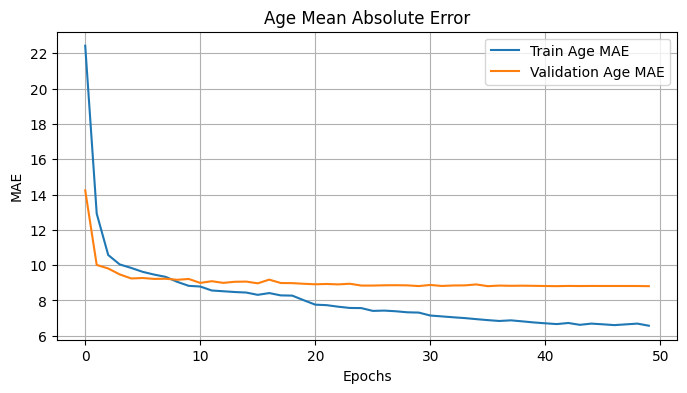

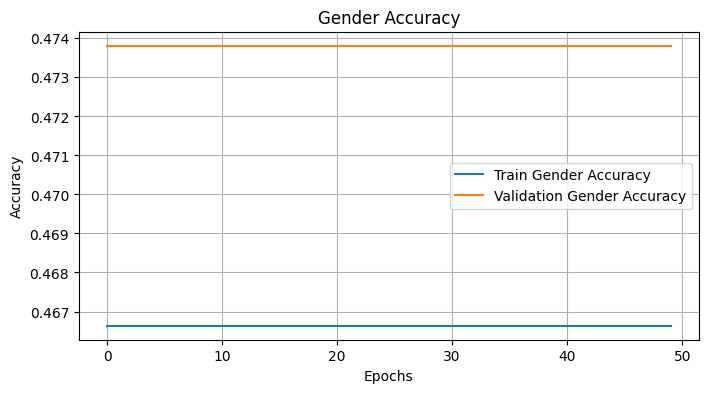

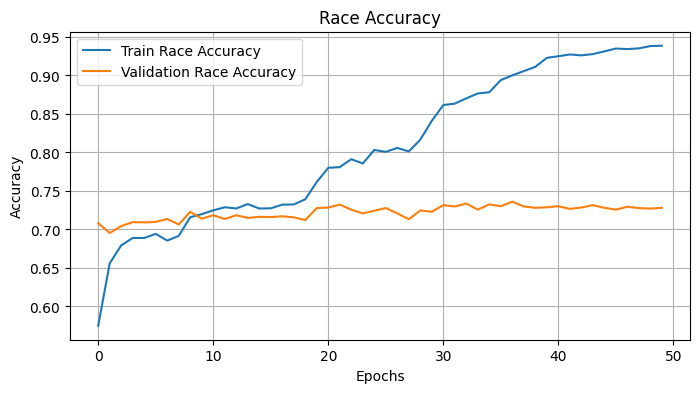

In [60]:
# Plot evaluation metrics for age, gender, and race
plt.figure(figsize=(8, 4))
plt.plot(history.history['age_mae'], label='Train Age MAE')
plt.plot(history.history['val_age_mae'], label='Validation Age MAE')
plt.title('Age Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.history['gender_accuracy'], label='Train Gender Accuracy')
plt.plot(history.history['val_gender_accuracy'], label='Validation Gender Accuracy')
plt.title('Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.history['race_accuracy'], label='Train Race Accuracy')
plt.plot(history.history['val_race_accuracy'], label='Validation Race Accuracy')
plt.title('Race Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [61]:
# Evaluate on the test dataset
test_loss, test_age_loss, test_gender_loss, test_race_loss, test_age_mae, test_gender_accuracy, test_race_accuracy = model.evaluate(test_ds)
print('Test Gender Accuracy:', test_gender_accuracy)
print('Test Race Accuracy:', test_race_accuracy)
print('Test Age MAE:', test_age_mae)


91/91 [==============================] - 319s 3s/step - loss: 10.2595 - age_loss: 7.9767 - gender_loss: 0.2765 - race_loss: 0.9686 - age_mae: 8.4609 - gender_accuracy: 0.4742 - race_accuracy: 0.7173
Test Gender Accuracy: 0.47417354583740234
Test Race Accuracy: 0.7172865271568298
Test Age MAE: 8.460914611816406


In [62]:
# Save model efficientnet h5 and history pickle
with open('../models/history.pkl', 'wb') as file:
    pickle.dump(history.history, file)
model.save('../models/efficientnet_v2s_dev.h5')
model.save('../models/efficientnet_v2s_dev')

INFO:tensorflow:Assets written to: ../models/efficientnet_v2s_dev/assets


INFO:tensorflow:Assets written to: ../models/efficientnet_v2s_dev/assets


1/1 [==============================] - 1s 618ms/step


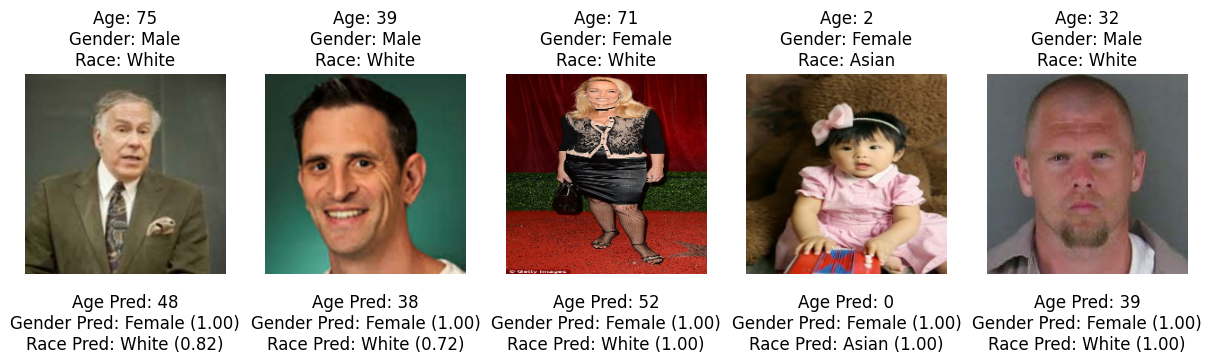

In [71]:
# Show preview image with true label and prediction from data test
for images, labels in test_ds.take(1):
    batch_size = images.shape[0]
    num_images = 5
    selected_indices = random.sample(range(batch_size), num_images)
    selected_images = tf.gather(images, selected_indices)

    ages = tf.gather(labels[0], selected_indices)
    genders = tf.gather(labels[1], selected_indices)
    races = tf.gather(labels[2], selected_indices)

    predictions = model.predict(selected_images)
    pred_ages = predictions[0].flatten()
    pred_genders = predictions[1].flatten()
    pred_races = predictions[2].argmax(axis=1)
    pred_race_confidences = predictions[2].max(axis=1)

    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        true_age = ages[i].numpy()
        true_gender = 'Male' if genders[i].numpy() == 0 else 'Female'
        true_race = ['White', 'Black', 'Asian', 'Indian', 'Others'][races[i].numpy()]

        pred_age = int(pred_ages[i])
        pred_gender = 'Male' if pred_genders[i] < 0.5 else 'Female'
        gender_confidence = 1 - pred_genders[i] if pred_genders[i] < 0.5 else pred_genders[i]
        pred_race = ['White', 'Black', 'Asian', 'Indian', 'Others'][pred_races[i]]
        race_confidence = pred_race_confidences[i]

        plt.subplot(1, num_images, i + 1)

        plt.imshow(selected_images[i].numpy().astype("uint8"))
        plt.title(f"Age: {true_age}\nGender: {true_gender}\nRace: {true_race}")
        plt.axis('off')

        plt.text(0.5, -0.1,
                 f"Age Pred: {pred_age}\nGender Pred: {pred_gender} ({gender_confidence:.2f})\nRace Pred: {pred_race} ({race_confidence:.2f})",
                 fontsize=12, ha='center', va='top', transform=plt.gca().transAxes)

    plt.show()

1/1 [==============================] - 3s 3s/step


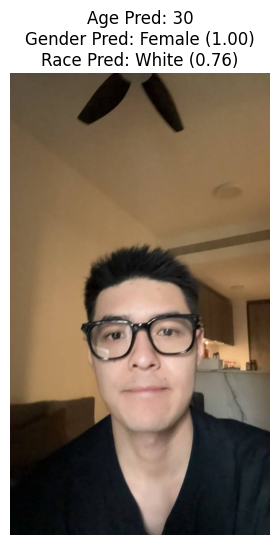

In [70]:
# Predict image from directory
def predict_and_display(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(image)
    image = tf.expand_dims(image, axis=0)

    model = tf.keras.models.load_model("../models/efficientnet_v2s_dev.h5")
    age_pred, gender_pred, race_pred = model.predict(image)
    age_pred = int(age_pred[0][0])

    raw_gender_pred = gender_pred[0][0]
    gender_pred = "Male" if raw_gender_pred < 0.5 else "Female"
    gender_confidence = 1 - raw_gender_pred if gender_pred == "Male" else raw_gender_pred

    race_labels = ["White", "Black", "Asian", "Indian", "Others"]
    race_pred_label = race_labels[np.argmax(race_pred[0])]
    race_confidence = np.max(race_pred[0])

    # Load the original image for display
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Plotting the result
    plt.figure(figsize=(6, 6))
    plt.imshow(original_image)
    plt.axis("off")
    plt.title(f"Age Pred: {age_pred}\nGender Pred: {gender_pred} ({gender_confidence:.2f})\nRace Pred: {race_pred_label} ({race_confidence:.2f})")
    plt.show()

# Predict and display the result
predict_and_display('../data_test/123.jpg')